# Prevendo notas matemática com Python


As notas se apresentam como variáveis importantes para prever a nota de matemática, sem falar que existem vários valores ausentes nelas e também muitos ausentes na coluna alvo (nota mat).

Antes começar manusear os missings e testar um modelo de regressão (random forest ou SVM), podemos usar algum modelo simples e robusto para preencher os missings das notas, pois temos o ID da prova (CO_PROVA_CH), o gabarito e a resposta do aluno, assim sendo simples determinar sua pontuação.

Tods as colunas *TX_* vão cair fora pois se tratam de respostas e gabaritos com missings colineares com outras colunas de bastante missings (aparecem juntos), além de que elas não aparecem no teste.

In [1]:
# bibliotecas
import pandas as pd
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from fancyimpute import KNN, IterativeImputer, SoftImpute
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  GridSearchCV
from sklearn.metrics import mean_squared_error as MSE
# mostrar todas as colunas e informação na saída do prompt (head ou info)
pd.set_option('display.max_columns', None)
%matplotlib inline

Using TensorFlow backend.


In [2]:
# lendo dados
treino = pd.read_csv('train.csv', index_col=0)
teste = pd.read_csv('test.csv', index_col=0)

In [3]:
treino.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,NO_ENTIDADE_CERTIFICACAO,CO_UF_ENTIDADE_CERTIFICACAO,SG_UF_ENTIDADE_CERTIFICACAO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TX_RESPOSTAS_CN,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,1,1,4314902.0,Porto Alegre,43.0,RS,1,4,1,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,4314902,Porto Alegre,43,RS,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,ABACCABDBEDEDEEDDDBBBDAABABECDCCCAAABCBEEABCA,BBEBCAEBCEDBDDEBCACDBCBDABDDCDBEDCEAEABCAADAC,99999DCABCABCBBCADBCBBABAEADBEEBEDAAABAEAECCBB...,AECCCBABDCADDBCBCCADADBBAADEBCEEBABCDDEAABCAA,1,BCADBCEDCCBADBDCADBEBDBEADCCAEACDBEDBCACAEBEE,BCBCCADCCBEDDBEEADBDCECCBBECAEEDDADCDDACAADBA,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBC...,DADCCECBDECADCBACDBCEEABDDAABDBCEADDBECEBAEBC,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,B,B,3,C,A,B,B,B,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,3,1,2304707.0,Granja,23.0,CE,2,0,2,1.0,0,23005157.0,2304707.0,Granja,23.0,CE,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,2304707,Granja,23,CE,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,EDAAABDABADBCCAEDCDDECABADBEECBBAEEDCABCAABBC,ADCAABAADCEDAACDACEEDACBDCBACEDEDBACAADADABDC,99999ACBACDBDBCEADDAEEADCCEACEEDBECAAAACBECDAC...,AEDACBDECEDAEEAEDDEBDECDCECACADCACACAABDACEAB,1,EBEECADBCABECDDBEADCCABDEABEBCADBADDCCCEDBBCA,DCECBAAADCBBECAEDCEDDACCBDDACEDDBADBCADBCBCEE,CEDEACCBEBDBABECABDADEADCEDCBEBBCEBAAEBAAECBBC...,DADCCECBDECADCBACDBCEEABDDAABDBCEADDBECEBAEBC,1.0

In [4]:
teste.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73ff9fcc02f0a99919906c942c2e1a1042cdcf98,41,PR,22,F,3,1,1,5,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,464.8,443.5,431.8,0,1.0,120.0,80.0,80.0,100.0,40.0,420.0,B,A,C,A,A,C,C,A
71a95f9f1b91a82c65ad94abbdf9f54e6066f968,21,MA,26,F,3,1,1,8,1,NaN,0,NaN,0,0,0,0,0,0,0,0,1,1,1,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,f48d390ab6a2428e659c37fb8a9d00afde621889,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,391.1,491.1,548.0,1,1.0,120.0,120.0,120.0,120.0,100.0,580.0,E,B,C,B,B,B,F,A
b38a03232f43b11c9d0788abaf060f7366053b6d,23,CE,21,M,1,1,2,0,2,3.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,595.9,622.7,613.6,0,1.0,80.0,40.0,40.0,80.0,80.0,320.0,E,E,D,B,B,A,NaN,A
70b682d9a3636be23f6120fa9d6b164eb3c6002d,15,PA,27,F,3,1,1,8,1,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,G,B,B,A,NaN,A
715494628a50142ce8cb17191cfe6d0f3cae0934,41,PR,18,M,1,1,2,0,2,1.0,0,2.0,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,592.9,492.6,571.4,1,1.0,100.0,80.0,60.0,80.0,0.0,320.0,D,H,H,C,B,A,NaN,A


In [5]:
print('dimTreino', treino.shape, '\ndimTeste', teste.shape)

dimTreino (13730, 166) 
dimTeste (4576, 46)


Algumas colunas devem ser removidas, pois havia duplicidade de informação (código do estado e sigla do estado, por exemplo).

In [6]:
colsRemov = [
    # removendo ID do candidato (alta cardinalidade)
    'NU_INSCRICAO',
    'NU_ANO',
    # tiram ID de nome, deixando os CODIGO
    'NO_MUNICIPIO_RESIDENCIA',
    # esse preciso deixar pois existe conjunto TESTE
    #'SG_UF_RESIDENCIA',
    # então retiro o código
    'CO_UF_RESIDENCIA',
    'NO_MUNICIPIO_NASCIMENTO',
    'SG_UF_NASCIMENTO',
    # informação de localização já existe no municipio
    'CO_ESCOLA',
    'CO_MUNICIPIO_ESC',
    'NO_MUNICIPIO_ESC',
    'CO_UF_ESC',
    'SG_UF_ESC',
    # aparentemente informação irrelevante
    'NO_ENTIDADE_CERTIFICACAO',
    'NO_MUNICIPIO_PROVA',
    'SG_UF_PROVA',
    # removendo respostas e gabarito
    'TX_RESPOSTAS_CN',
    'TX_RESPOSTAS_CH',
    'TX_RESPOSTAS_LC',               
    'TX_RESPOSTAS_MT',               
    'TX_GABARITO_CN',                
    'TX_GABARITO_CH',                
    'TX_GABARITO_LC',                
    'TX_GABARITO_MT',        
    # colunas com alta cardinalidade (muitos items)
    # identificacao das cidades
    'CO_MUNICIPIO_RESIDENCIA', 
    'CO_MUNICIPIO_NASCIMENTO', 
    'CO_MUNICIPIO_PROVA',
    # informação redundantes pois já tenho o estado onde de residência
    'CO_UF_NASCIMENTO',
    'CO_UF_PROVA'
]    

In [7]:
treino.shape

(13730, 166)

In [8]:
# removendo colunas do treino
treino.drop(colsRemov, axis=1, inplace=True)
treino.shape

(13730, 139)

In [9]:
teste.shape

(4576, 46)

In [10]:
# removendo essas colunas do teste (caso estejam presentes)
for coluna in list(teste.columns):
    if coluna in colsRemov:
        teste.drop(coluna, axis=1, inplace=True)
        
teste.shape

(4576, 45)

In [11]:
treino.head()

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,CO_UF_ENTIDADE_CERTIFICACAO,SG_UF_ENTIDADE_CERTIFICACAO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q028,Q029,Q030,Q031,Q032,Q033,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
1,RS,24,M,0.0,1,1,1,4,1,NaN,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,B,B,3,C,A,B,B,B,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,E,5.0,5.0,1.0,0.0,0.0,5,5,0,5,5,5,5,5.0,A,A,A,A,A,A,A,B,D
2,CE,17,F,0.0,3,1,2,0,2,1.0,0,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,A,A,5,B,A,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,1,1,1,1,1,NaN,A,A,C,A,B,A,A,C,A
3,CE,21,F,0.0,3,1,3,0,1,NaN,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,D,B,B,4,C,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,A,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,5,5,5,5,5,5,NaN,A,A,A,A,C,A,A,B,A
4,RJ,25,F,0.0,0,1,1,9,1,NaN,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,D,B,4,E,A,C,C,C,A,B,B,B,A,B,A,B,C,A,B,D,B,C,B,C,F,C,2.0,0.0,5.0,5.0,5.0,5,5,5,5,2,5,5,5.0,C,A,A,A,A,D,A,A,A
5,AM,28,M,0.0,2,1,1,4,1,NaN,0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,Na

In [12]:
treino.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13730 entries, 1 to 4586
Data columns (total 139 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   SG_UF_RESIDENCIA             object 
 1   NU_IDADE                     int64  
 2   TP_SEXO                      object 
 3   TP_ESTADO_CIVIL              float64
 4   TP_COR_RACA                  int64  
 5   TP_NACIONALIDADE             int64  
 6   TP_ST_CONCLUSAO              int64  
 7   TP_ANO_CONCLUIU              int64  
 8   TP_ESCOLA                    int64  
 9   TP_ENSINO                    float64
 10  IN_TREINEIRO                 int64  
 11  TP_DEPENDENCIA_ADM_ESC       float64
 12  TP_LOCALIZACAO_ESC           float64
 13  TP_SIT_FUNC_ESC              float64
 14  IN_BAIXA_VISAO               int64  
 15  IN_CEGUEIRA                  int64  
 16  IN_SURDEZ                    int64  
 17  IN_DEFICIENCIA_AUDITIVA      int64  
 18  IN_SURDO_CEGUEIRA            int64  
 19  IN_D

In [13]:
pd.set_option('display.expand_frame_repr', False)

## Checando a porcentagem de missings (valores ausentes)

In [14]:
def porcentNA(df, nomeDf):
    # calcula e printa a porcentagem de valores ausentes
    # em cada coluna do DF
    # retorna a tabela com os percentuais
    
    # calcula porcentagem de missings
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'percent_missing': percent_missing})
    missing_value_df.sort_values('percent_missing', inplace=True)
    percentualMiss = df.isnull().sum() * 100 / len(df)

    # mostra porcentagem de MISSINGS
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
        print(nomeDf+' - PORCENTAGEM de NA em cada COLUNA'+'\n\n',percentualMiss)
    
    return percentualMiss

In [15]:
naTreinoDf = porcentNA(treino, 'Treino')

Treino - PORCENTAGEM de NA em cada COLUNA

 SG_UF_RESIDENCIA                0.000000
NU_IDADE                        0.000000
TP_SEXO                         0.000000
TP_ESTADO_CIVIL                 3.845594
TP_COR_RACA                     0.000000
TP_NACIONALIDADE                0.000000
TP_ST_CONCLUSAO                 0.000000
TP_ANO_CONCLUIU                 0.000000
TP_ESCOLA                       0.000000
TP_ENSINO                      68.812819
IN_TREINEIRO                    0.000000
TP_DEPENDENCIA_ADM_ESC         68.812819
TP_LOCALIZACAO_ESC             68.812819
TP_SIT_FUNC_ESC                68.812819
IN_BAIXA_VISAO                  0.000000
IN_CEGUEIRA                     0.000000
IN_SURDEZ                       0.000000
IN_DEFICIENCIA_AUDITIVA         0.000000
IN_SURDO_CEGUEIRA               0.000000
IN_DEFICIENCIA_FISICA           0.000000
IN_DEFICIENCIA_MENTAL           0.000000
IN_DEFICIT_ATENCAO              0.000000
IN_DISLEXIA                     0.000000
IN_DISCALCULI

In [16]:
naTesteDf = porcentNA(teste, "Teste")

Teste - PORCENTAGEM de NA em cada COLUNA

 SG_UF_RESIDENCIA           0.000000
NU_IDADE                   0.000000
TP_SEXO                    0.000000
TP_COR_RACA                0.000000
TP_NACIONALIDADE           0.000000
TP_ST_CONCLUSAO            0.000000
TP_ANO_CONCLUIU            0.000000
TP_ESCOLA                  0.000000
TP_ENSINO                 67.657343
IN_TREINEIRO               0.000000
TP_DEPENDENCIA_ADM_ESC    67.657343
IN_BAIXA_VISAO             0.000000
IN_CEGUEIRA                0.000000
IN_SURDEZ                  0.000000
IN_DISLEXIA                0.000000
IN_DISCALCULIA             0.000000
IN_SABATISTA               0.000000
IN_GESTANTE                0.000000
IN_IDOSO                   0.000000
TP_PRESENCA_CN             0.000000
TP_PRESENCA_CH             0.000000
TP_PRESENCA_LC             0.000000
CO_PROVA_CN                0.000000
CO_PROVA_CH                0.000000
CO_PROVA_LC                0.000000
CO_PROVA_MT                0.000000
NU_NOTA_CN           

Vamos remover as colunas com mais de 50% dos missings
O *TP_DEPENDENCIA_ADM_ESC* (estadual, privada, federal) e *Q027* (quantos anos começou trabalhar) apesar de muitos NAs (68% e 53%) serão poupados por aparecerem no teste e serem features relevantes.                       

In [17]:
colsPoupar = ['TP_DEPENDENCIA_ADM_ESC', 'Q027']

In [18]:
# selcionar naTreinoDf < 50 or index in ['TP_DEPENDENCIA_ADM_ESC', 'Q027']

# montando vetores logicos para manter essas colunas
pouparTreino = np.zeros(len(naTreinoDf))
pouparTeste = np.zeros(len(naTesteDf))

for col in colsPoupar:
    pouparTreino[(list(naTreinoDf.index)).index(col)] = 1
    pouparTeste[(list(naTesteDf.index)).index(col)] = 1
    
for i in np.arange(len(naTreinoDf)):
    pouparTreino[i] = (naTreinoDf < 50)[i] or pouparTreino[i]
    
for i in np.arange(len(naTesteDf)):
    pouparTeste[i] = (naTesteDf < 50)[i] or pouparTeste[i]
    
# convertendo para booleano
pouparTreino = pouparTreino.astype(bool)
pouparTeste = pouparTeste.astype(bool)

In [19]:
pouparTeste

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [20]:
print(treino.shape, teste.shape)

(13730, 139) (4576, 45)


In [21]:
naTreinoDf = naTreinoDf.loc[pouparTreino]
naTesteDf = naTesteDf.loc[pouparTeste]

In [22]:
treino = treino[list(naTreinoDf.index)]
teste = teste[list(naTesteDf.index)]

In [23]:
print(treino.shape, teste.shape)

(13730, 127) (4576, 44)


In [24]:
treino.head()

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
1,RS,24,M,0.0,1,1,1,4,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,B,B,3,C,A,B,B,B,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,H,5,5,0,5,5,5,5,A,A,A,A,A,A,A,B,D
2,CE,17,F,0.0,3,1,2,0,2,0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,A,A,5,B,A,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,NaN,5,5,1,1,1,1,1,A,A,C,A,B,A,A,C,A
3,CE,21,F,0.0,3,1,3,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,D,B,B,4,C,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,A,A,NaN,5,5,5,5,5,5,5,A,A,A,A,C,A,A,B,A
4,RJ,25,F,0.0,0,1,1,9,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,D,B,4,E,A,C,C,C,A,B,B,B,A,B,A,B,C,A,B,D,B,C,B,C,F,5,5,5,5,2,5,5,C,A,A,A,A,D,A,A,A
5,AM,28,M,0.0,2,1,1,4,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,D,C,C,4,C,A,B,C,A,A,B,A,B,A,A,A,A,B,A,A,B,A,A,A,B,F,5,5,4,3,1,4,5,A,A,A,A,A,A,A,A,A


## Visualizando os missings

Na questão de usar o gabarito e as respostas do alunos para prever notas ausentes, caso esses valores ausentes apareçam juntos de nada adianta, então as colunas dos gabaritos podem ser excluidas.

Vamos visualizar a correlação dos missings.

In [25]:
# paleta de cores
default_color = '#56B4E9'
colormap = plt.cm.cool
#plt.style.use('dark_background')
plt.style.use('classic')

In [26]:
# pegandos apenas missings
missingValueColumns = treino.columns[treino.isnull().any()].tolist()
nuloDf = treino[missingValueColumns] 

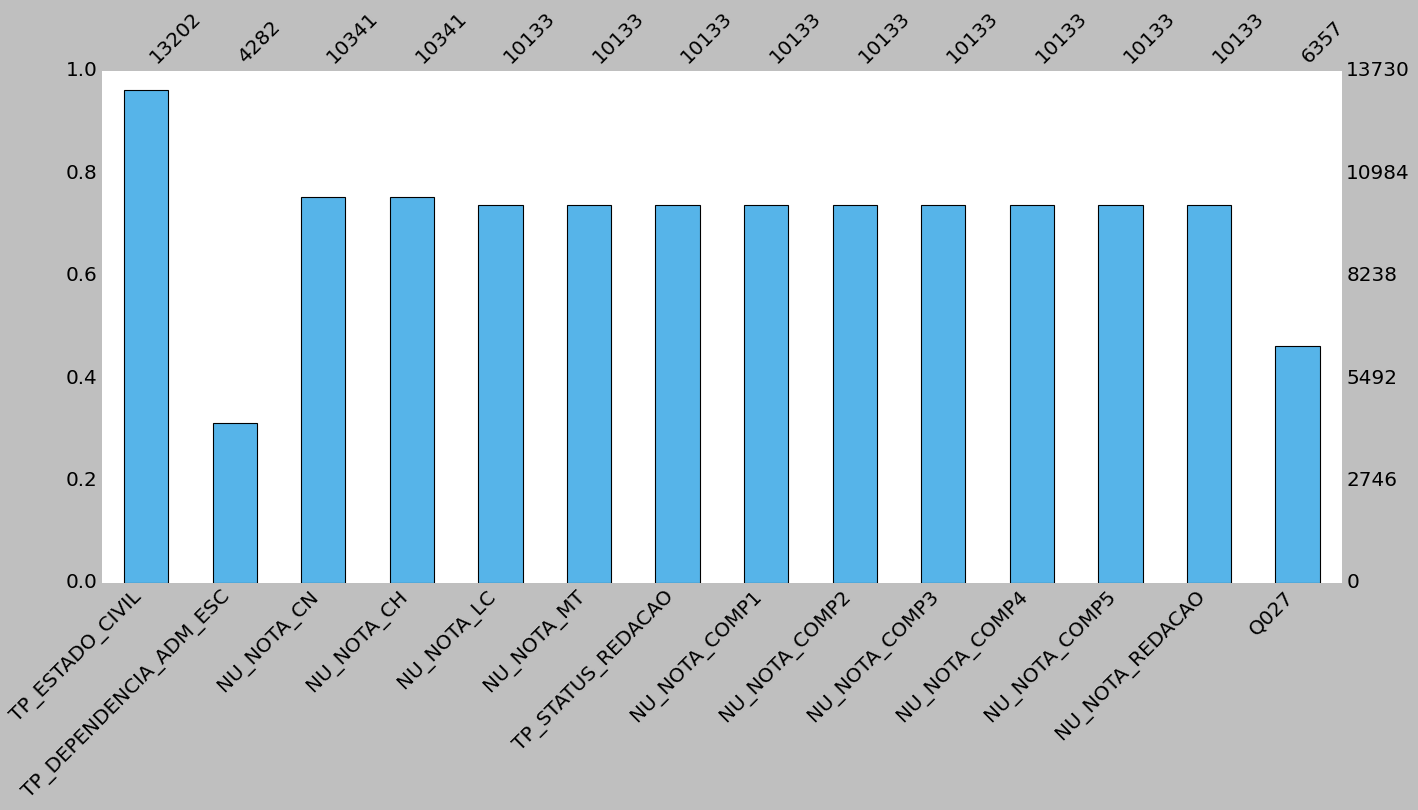

In [27]:
msno.bar(nuloDf,figsize=(20,8),color=default_color,fontsize=18,labels=True)

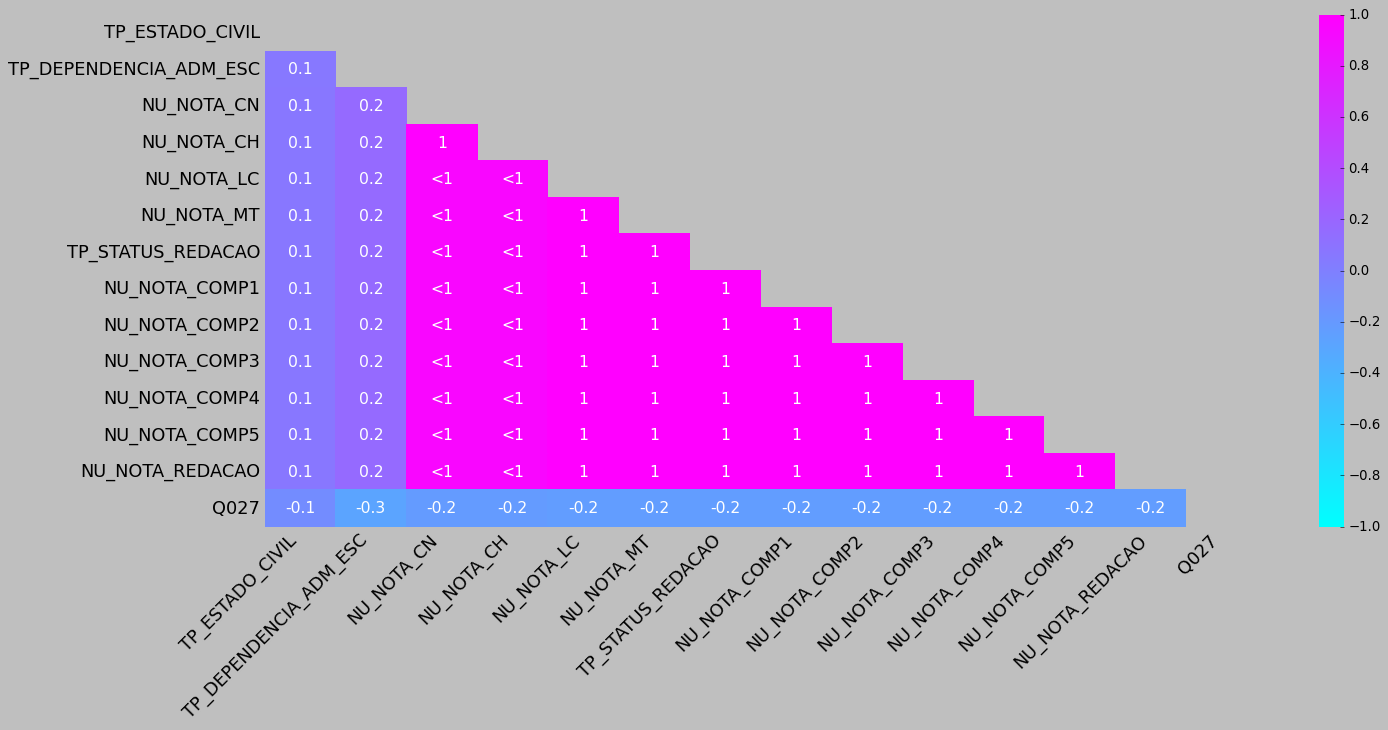

In [28]:
msno.heatmap(nuloDf, figsize=(20,8), cmap=colormap)

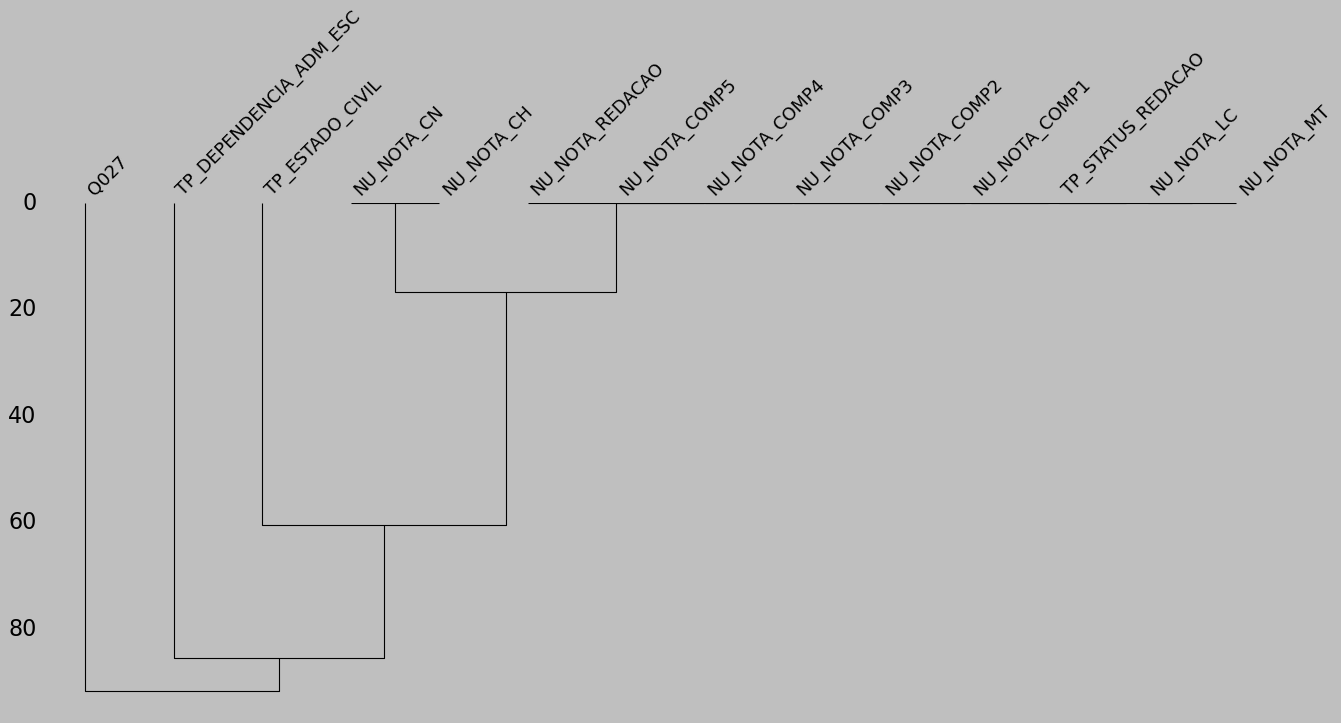

In [29]:
msno.dendrogram(nuloDf,figsize=(20,8))

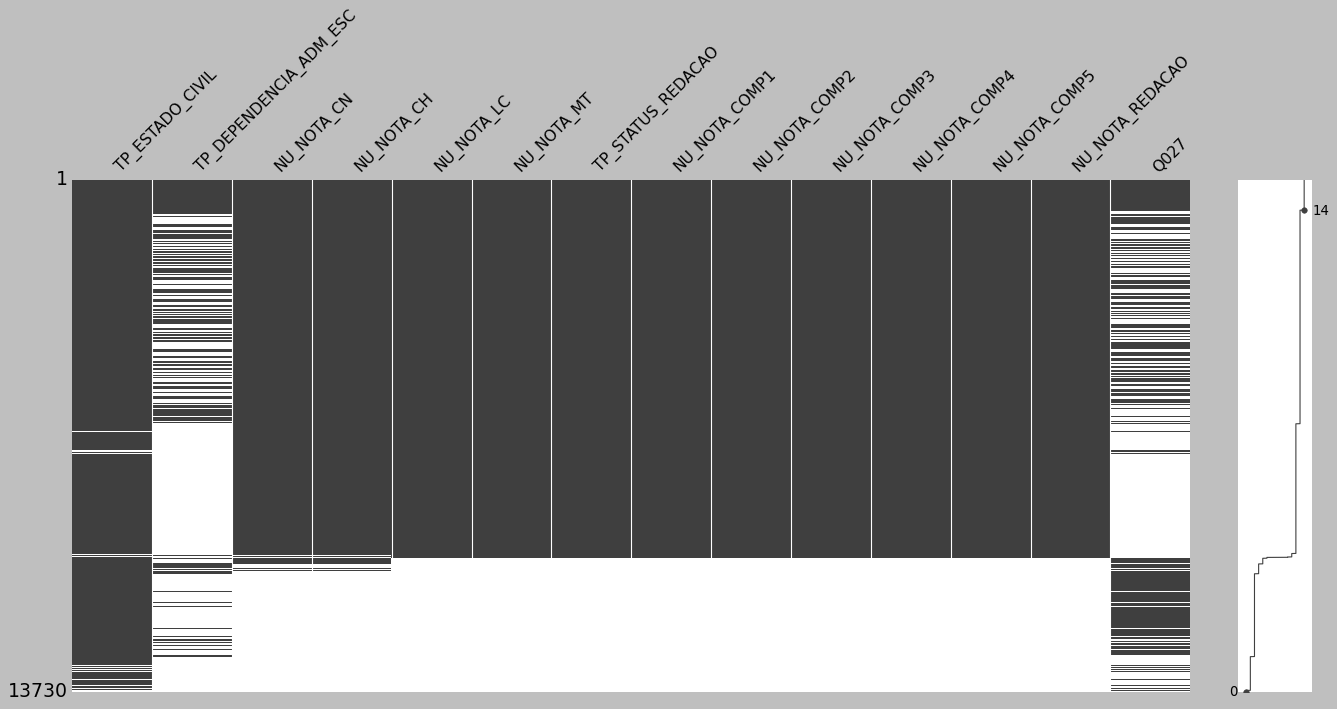

In [30]:
sorted_data = msno.nullity_sort(nuloDf, sort='descending') # or sort='ascending'
msno.matrix(sorted_data,figsize=(20,8),fontsize=14)

Acima vemos que os valores fantants caminham juntos e representam em torno de 25% dos dados.

Dessa podemos tentar removê-los ou preenchê-los.

## Visualizando o Alvo

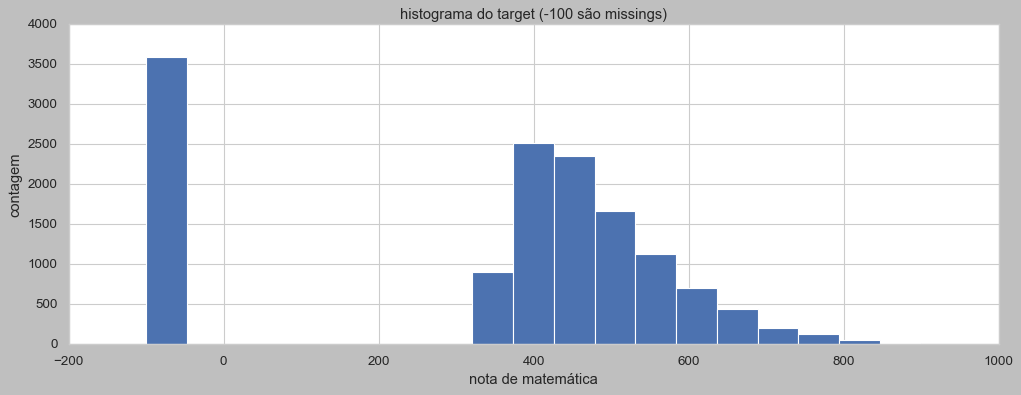

In [31]:
# auxiliar para enchegar missings
aux = treino.copy()
aux = aux.fillna(-100)

plt.figure(figsize=(15,5))
plt.style.use('dark_background')

sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [8, 5]})

sns.distplot(
    aux['NU_NOTA_MT'], norm_hist=False, kde=False, bins=20, hist_kws={"alpha": 1}
).set(xlabel='nota de matemática', ylabel='contagem', title='histograma do target (-100 são missings)');

# deletando auxiliar
del aux

## Relação das variáveis contínuas

In [32]:
# variaveis numericas continuas
numContin = ['NU_NOTA_CN','NU_NOTA_CH','NU_NOTA_LC','NU_NOTA_MT']

# variaveis numericas inteiras
numDisc = ['NU_IDADE','NU_NOTA_COMP1','NU_NOTA_COMP2','NU_NOTA_COMP3','NU_NOTA_COMP4','NU_NOTA_COMP5','NU_NOTA_REDACAO']

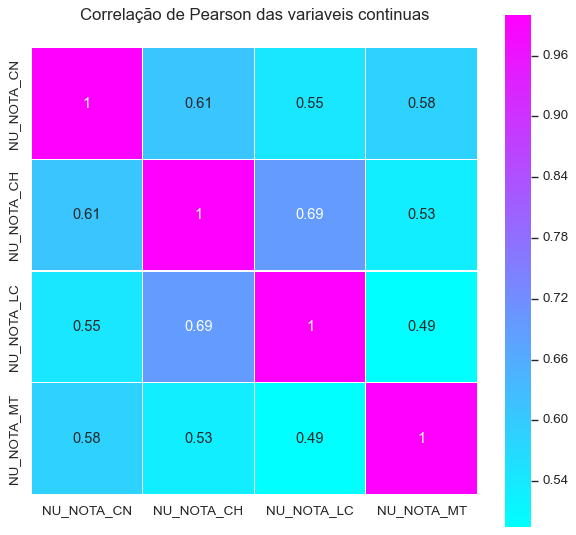

In [33]:
plt.figure(figsize=(18*.5,16*.5))
plt.title('Correlação de Pearson das variaveis continuas', y=1.05, size=15)
sns.heatmap(treino[numContin].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

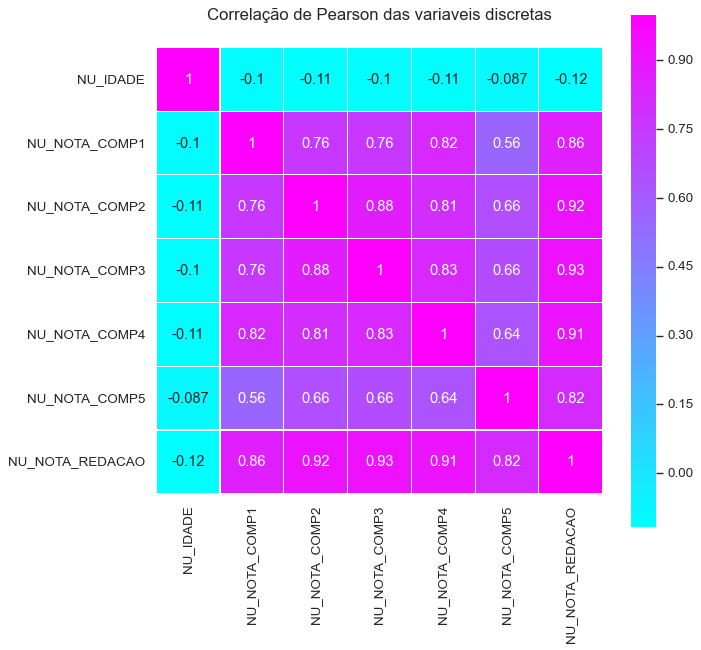

In [34]:
# esse grafico não faz sentidos (pois são numeros inteira)
# mas vamos visualizar por curiosidade hehe
plt.figure(figsize=(18*.5,16*.5))
plt.title('Correlação de Pearson das variaveis discretas', y=1.05, size=15)
sns.heatmap(treino[numDisc].corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# Limpando os dados

## Tipos das variáveis

* numérica discreta (idade, notas inteiras)
* numérica contínua (notas quebradas)
* categóricas nominais / dummies (estado, cidade, tipo escola)
* categóricas ordinais (renda, qualificação dos pais)
* categóricas binárias (sexo, sim/não)

In [35]:
def tiposVariaveis(df):
    # recebe p DF
    # retorna dicionario o nomes das variaveis na ordem
    # numDisc, numCont, categNom, categOrd, categBin
    numDisc = []
    numCont = []
    # binárias vão entrar em nominal
    categNom = []
    categOrd = []
    categBin = []

    # classificando as colunas de acordo com o tipo delas
    for col in df.columns:

        if 'Q0' in col:
            if col in ['Q018','Q020','Q021','Q023','Q025']:
                categBin.append(col)
            else:
                categOrd.append(col)

        if any(list(map(lambda x: x in col, ['IN_','CO_','SG_','TP_','TX_']))):
            if any(list(map(lambda x: x in col, ['IN_','TP_SEXO','TP_LINGUA']))):
                categBin.append(col)
            else:
                categNom.append(col)

        if col in 'NU_IDADE':
            numDisc.append(col)


        if 'NU_NOTA_' in col:
            if any(list(map(lambda x: x in col, ['NU_NOTA_COMP','NU_NOTA_REDACAO']))):
                numDisc.append(col)
            else:
                numCont.append(col)

    return {'numDisc':numDisc, 'numCont':numCont,
            'categNom':categNom, 'categOrd':categOrd, 'categBin':categBin}

In [36]:
colsTreino = tiposVariaveis(treino)
colsTeste = tiposVariaveis(teste)

In [37]:
colsTreino

{'numDisc': ['NU_IDADE',
  'NU_NOTA_COMP1',
  'NU_NOTA_COMP2',
  'NU_NOTA_COMP3',
  'NU_NOTA_COMP4',
  'NU_NOTA_COMP5',
  'NU_NOTA_REDACAO'],
 'numCont': ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT'],
 'categNom': ['SG_UF_RESIDENCIA',
  'TP_ESTADO_CIVIL',
  'TP_COR_RACA',
  'TP_NACIONALIDADE',
  'TP_ST_CONCLUSAO',
  'TP_ANO_CONCLUIU',
  'TP_ESCOLA',
  'TP_DEPENDENCIA_ADM_ESC',
  'TP_PRESENCA_CN',
  'TP_PRESENCA_CH',
  'TP_PRESENCA_LC',
  'TP_PRESENCA_MT',
  'CO_PROVA_CN',
  'CO_PROVA_CH',
  'CO_PROVA_LC',
  'CO_PROVA_MT',
  'TP_STATUS_REDACAO'],
 'categOrd': ['Q001',
  'Q002',
  'Q003',
  'Q004',
  'Q005',
  'Q006',
  'Q007',
  'Q008',
  'Q009',
  'Q010',
  'Q011',
  'Q012',
  'Q013',
  'Q014',
  'Q015',
  'Q016',
  'Q017',
  'Q019',
  'Q022',
  'Q024',
  'Q026',
  'Q027',
  'Q034',
  'Q035',
  'Q036',
  'Q037',
  'Q038',
  'Q039',
  'Q040',
  'Q042',
  'Q043',
  'Q044',
  'Q045',
  'Q046',
  'Q047',
  'Q048',
  'Q049',
  'Q050'],
 'categBin': ['TP_SEXO',
  'IN_TREINEIRO',
 

In [38]:
colsTeste

{'numDisc': ['NU_IDADE',
  'NU_NOTA_COMP1',
  'NU_NOTA_COMP2',
  'NU_NOTA_COMP3',
  'NU_NOTA_COMP4',
  'NU_NOTA_COMP5',
  'NU_NOTA_REDACAO'],
 'numCont': ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC'],
 'categNom': ['SG_UF_RESIDENCIA',
  'TP_COR_RACA',
  'TP_NACIONALIDADE',
  'TP_ST_CONCLUSAO',
  'TP_ANO_CONCLUIU',
  'TP_ESCOLA',
  'TP_DEPENDENCIA_ADM_ESC',
  'TP_PRESENCA_CN',
  'TP_PRESENCA_CH',
  'TP_PRESENCA_LC',
  'CO_PROVA_CN',
  'CO_PROVA_CH',
  'CO_PROVA_LC',
  'CO_PROVA_MT',
  'TP_STATUS_REDACAO'],
 'categOrd': ['Q001', 'Q002', 'Q006', 'Q024', 'Q026', 'Q027', 'Q047'],
 'categBin': ['TP_SEXO',
  'IN_TREINEIRO',
  'IN_BAIXA_VISAO',
  'IN_CEGUEIRA',
  'IN_SURDEZ',
  'IN_DISLEXIA',
  'IN_DISCALCULIA',
  'IN_SABATISTA',
  'IN_GESTANTE',
  'IN_IDOSO',
  'TP_LINGUA',
  'Q025']}

## Correção das variáveis

Aqui vamos corrigir as variáveis. 

Binárias que estão como string serão convertidas em 0/1.

As categóricas ordinais que são string (A, B, C...) serão convertidas em números (1, 2, 3...)

As Dummyes serão quebradas em colunas na configuração one-hot-encoding.

## Binárias

In [39]:
def corrigeBinarias(df):
    # corrigindo binárias para numéricas
    # recebe o DF e nada retorna
    
    # colunas binarias
    corrigir = [
        'TP_SEXO',
        'Q018',
        'Q020',
        'Q021',
        'Q023',
        'Q025']

    def caracParaBin(char):
        if char == 'A' or char == 'M':
            return 0
        elif char == 'B' or char == 'F':
            return 1
        else:
            return np.nan

    def colCaracParaBin(col):
        df[col] = df[col].apply(caracParaBin)
    
    # faz a correção
    for coluna in corrigir:
        if coluna in list(df.columns):
            colCaracParaBin(coluna)



In [40]:
# corrigindo variaveis
corrigeBinarias(treino)
corrigeBinarias(teste)

In [41]:
treino.head()

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
1,RS,24,0,0.0,1,1,1,4,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,D,D,B,B,3,C,A,B,B,B,A,B,A,A,A,A,A,0,B,0,0,C,0,A,0,C,H,5,5,0,5,5,5,5,A,A,A,A,A,A,A,B,D
2,CE,17,1,0.0,3,1,2,0,2,0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,A,A,5,B,A,B,B,A,A,B,A,A,A,A,A,0,B,0,0,A,0,A,0,A,NaN,5,5,1,1,1,1,1,A,A,C,A,B,A,A,C,A
3,CE,21,1,0.0,3,1,3,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,D,B,B,4,C,A,B,C,A,A,B,A,A,A,A,A,0,B,0,0,B,0,A,0,A,NaN,5,5,5,5,5,5,5,A,A,A,A,C,A,A,B,A
4,RJ,25,1,0.0,0,1,1,9,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,D,B,4,E,A,C,C,C,A,B,B,B,A,B,A,1,C,0,1,D,1,C,1,C,F,5,5,5,5,2,5,5,C,A,A,A,A,D,A,A,A
5,AM,28,0,0.0,2,1,1,4,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E,D,C,C,4,C,A,B,C,A,A,B,A,B,A,A,A,0,B,0,0,B,0,A,0,B,F,5,5,4,3,1,4,5,A,A,A,A,A,A,A,A,A


In [42]:
teste.head()

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73ff9fcc02f0a99919906c942c2e1a1042cdcf98,PR,22,1,3,1,1,5,1,0,NaN,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,464.8,443.5,431.8,0,1.0,120.0,80.0,80.0,100.0,40.0,420.0,B,A,C,A,0,C,C,A
71a95f9f1b91a82c65ad94abbdf9f54e6066f968,MA,26,1,3,1,1,8,1,0,NaN,0,0,0,0,0,0,0,0,1,1,1,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,f48d390ab6a2428e659c37fb8a9d00afde621889,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,391.1,491.1,548.0,1,1.0,120.0,120.0,120.0,120.0,100.0,580.0,E,B,C,B,1,B,F,A
b38a03232f43b11c9d0788abaf060f7366053b6d,CE,21,0,1,1,2,0,2,0,2.0,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,595.9,622.7,613.6,0,1.0,80.0,40.0,40.0,80.0,80.0,320.0,E,E,D,B,1,A,NaN,A
70b682d9a3636be23f6120fa9d6b164eb3c6002d,PA,27,1,3,1,1,8,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,H,E,G,B,1,A,NaN,A
715494628a50142ce8cb17191cfe6d0f3cae0934,PR,18,0,1,1,2,0,2,0,2.0,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,592.9,492.6,571.4,1,1.0,100.0,80.0,60.0,80.0,0.0,320.0,D,H,H,C,1,A,NaN,A


## Categóricas Ordinais

In [43]:
colsTeste['categOrd']

['Q001', 'Q002', 'Q006', 'Q024', 'Q026', 'Q027', 'Q047']

In [44]:
def corrigeCategOrd(df, colsCategOrd):
    # corrige as variaveis categoricas ordinais
    # recebe DF e lista das Colunas Ordinais
    # nada retorna

    # corrigindo categoricas ordinais
    # algumas colunas estão como string (object)
    letras = {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,
              'I':9,'J':10,'K':11,'L':12,'M':13,'N':14,'O':15,'P':16,'Q':17}

    for col in colsCategOrd:
        if df[col].dtypes == np.object:
            df[col] = df[col].replace(letras)

In [45]:
corrigeCategOrd(treino, colsTreino['categOrd'])
corrigeCategOrd(teste, colsTeste['categOrd'])

In [46]:
treino.head()

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,TP_PRESENCA_MT,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
1,RS,24,0,0.0,1,1,1,4,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,436.3,495.4,581.2,399.4,1,1.0,120.0,120.0,120.0,80.0,80.0,520.0,4,4,2,2,3,3,1,2,2,2,1,2,1,1,1,1,1,0,2,0,0,3,0,1,0,3,8.0,5,5,0,5,5,5,5,1,1,1,1,1,1,1,2,4
2,CE,17,1,0.0,3,1,2,0,2,0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,909237ab0d84688e10c0470e2997348aff585273,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,474.5,544.1,599.0,459.8,1,1.0,140.0,120.0,120.0,120.0,80.0,580.0,1,1,1,1,5,2,1,2,2,1,1,2,1,1,1,1,1,0,2,0,0,1,0,1,0,1,NaN,5,5,1,1,1,1,1,1,1,3,1,2,1,1,3,1
3,CE,21,1,0.0,3,1,3,0,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,4,2,2,4,3,1,2,3,1,1,2,1,1,1,1,1,0,2,0,0,2,0,1,0,1,NaN,5,5,5,5,5,5,5,1,1,1,1,3,1,1,2,1
4,RJ,25,1,0.0,0,1,1,9,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,5,4,2,4,5,1,3,3,3,1,2,2,2,1,2,1,1,3,0,1,4,1,3,1,3,6.0,5,5,5,5,2,5,5,3,1,1,1,1,4,1,1,1
5,AM,28,0,0.0,2,1,1,4,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,4,3,3,4,3,1,2,3,1,1,2,1,2,1,1,1,0,2,0,0,2,0,1,0,2,6.0,5,5,4,3,1,4,5,1,1,1,1,1,1,1,1,1


In [47]:
teste.head()

,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,TP_PRESENCA_CN,TP_PRESENCA_CH,TP_PRESENCA_LC,CO_PROVA_CN,CO_PROVA_CH,CO_PROVA_LC,CO_PROVA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73ff9fcc02f0a99919906c942c2e1a1042cdcf98,PR,22,1,3,1,1,5,1,0,NaN,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01abbb7f1a90505385f44eec9905f82ca2a42cfd,81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,464.8,443.5,431.8,0,1.0,120.0,80.0,80.0,100.0,40.0,420.0,2,1,3,1,0,3,3.0,1
71a95f9f1b91a82c65ad94abbdf9f54e6066f968,MA,26,1,3,1,1,8,1,0,NaN,0,0,0,0,0,0,0,0,1,1,1,c8328ebc6f3238e06076c481bc1b82b8301e7a3f,f48d390ab6a2428e659c37fb8a9d00afde621889,72f80e4b3150c627c7ffc93cfe0fa13a9989b610,577f8968d95046f5eb5cc158608e12fa9ba34c85,391.1,491.1,548.0,1,1.0,120.0,120.0,120.0,120.0,100.0,580.0,5,2,3,2,1,2,6.0,1
b38a03232f43b11c9d0788abaf060f7366053b6d,CE,21,0,1,1,2,0,2,0,2.0,0,0,0,0,0,0,0,0,1,1,1,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,01af53cd161a420fff1767129c10de560cc264dd,97caab1e1533dba217deb7ef41490f52e459ab01,595.9,622.7,613.6,0,1.0,80.0,40.0,40.0,80.0,80.0,320.0,5,5,4,2,1,1,NaN,1
70b682d9a3636be23f6120fa9d6b164eb3c6002d,PA,27,1,3,1,1,8,1,0,NaN,0,0,0,0,0,0,0,0,0,0,0,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,2d22ac1d42e6187f09ee6c578df187a760123ccf,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,5,7,2,1,1,NaN,1
715494628a50142ce8cb17191cfe6d0f3cae0934,PR,18,0,1,1,2,0,2,0,2.0,0,0,0,0,0,0,0,0,1,1,1,66b1dad288e13be0992bae01e81f71eca1c6e8a6,942ab3dc020af4cf53740b6b07e9dd7060b24164,5aebe5cad7fabc1545ac7fba07a4e6177f98483c,767a32545304ed293242d528f54d4edb1369f910,592.9,492.6,571.4,1,1.0,100.0,80.0,60.0,80.0,0.0,320.0,4,8,8,3,1,1,NaN,1


## Categóricas Nominais (Dummy)

Existe um detalhe sutil na função para gerar as dummies no treino e no teste. Ela pega os valores únicos presentes dentro da coluna e gera as respectivas binárias. 

Caso existe algum valor que não pareça numa dummy do treino, é necessário pegar essa coluna que não aparece adiciona-la com valore ZERO. 

Para isso basta aplicar a função no treino (apenas colunas de teste) e ver se todas essas colunas estão presentes no conjunto de teste.

In [49]:
def corrigeDummies(df, colsCategNominal):
    # quebra uma coluna dummy em colunas one-hot-encoding
    # recebe DF e os nomes das colunas dummies
    # retorna o DF com dummies processadas
    
    for col in colsCategNominal:
        print(col, df.shape)
        # quebrando a coluna em dummies
        dummies = pd.get_dummies(col + '_' + df[col].astype(str))
        
        # pode surgir uma coluna dummy NAN, vamos retira-la
        # pois a função get_dummies considera nan como valor 
        # já que convertemos ele numa string
        if 'nan' in ('_'.join(list(dummies.columns))):
            # encontra nome da coluna Nan
            for col2 in list(dummies.columns):
                if 'nan' in col2:
                    colNan = col2
            # preenchendo os NANs reais
            dummies[dummies[colNan].astype(bool)] = np.nan
            # excluindo coluna NA
            dummies.drop(colNan, axis=1, inplace=True)
        
        # removendo ela do DF
        df.drop(col, axis=1, inplace=True)
        
        # obtendo nomes colunas dos DF sem a dummy 
        # e nome das dummies
        nomesDf = list(df.columns)
        nomesDummies = list(dummies.columns)
        
        # nome final colunas do DF
        colsDf = [nomesDf, nomesDummies]
        colsDf = np.hstack(colsDf)
        colsDf = list(colsDf)
        
        # concateno Dummy ao DF
        df = pd.concat([df, dummies], axis=1, ignore_index=True)
        # renomeando
        df.columns = colsDf
        print(col, df.shape)
    
    return df
    

In [50]:
# corrigindo dummies no treino apenas com colunas do teste
treinoColsTeste = treino[list(teste.columns)]

In [51]:
# corrigindo dummies
treino = corrigeDummies(treino, colsTreino['categNom'])

SG_UF_RESIDENCIA (13730, 127)
SG_UF_RESIDENCIA (13730, 153)
TP_ESTADO_CIVIL (13730, 153)
TP_ESTADO_CIVIL (13730, 156)
TP_COR_RACA (13730, 156)
TP_COR_RACA (13730, 161)
TP_NACIONALIDADE (13730, 161)
TP_NACIONALIDADE (13730, 165)
TP_ST_CONCLUSAO (13730, 165)
TP_ST_CONCLUSAO (13730, 168)
TP_ANO_CONCLUIU (13730, 168)
TP_ANO_CONCLUIU (13730, 178)
TP_ESCOLA (13730, 178)
TP_ESCOLA (13730, 181)
TP_DEPENDENCIA_ADM_ESC (13730, 181)
TP_DEPENDENCIA_ADM_ESC (13730, 184)
TP_PRESENCA_CN (13730, 184)
TP_PRESENCA_CN (13730, 186)
TP_PRESENCA_CH (13730, 186)
TP_PRESENCA_CH (13730, 188)
TP_PRESENCA_LC (13730, 188)
TP_PRESENCA_LC (13730, 190)
TP_PRESENCA_MT (13730, 190)
TP_PRESENCA_MT (13730, 192)
CO_PROVA_CN (13730, 192)
CO_PROVA_CN (13730, 201)
CO_PROVA_CH (13730, 201)
CO_PROVA_CH (13730, 210)
CO_PROVA_LC (13730, 210)
CO_PROVA_LC (13730, 218)
CO_PROVA_MT (13730, 218)
CO_PROVA_MT (13730, 226)
TP_STATUS_REDACAO (13730, 226)
TP_STATUS_REDACAO (13730, 234)


In [52]:
treinoColsTeste = corrigeDummies(treinoColsTeste, colsTeste['categNom'])

SG_UF_RESIDENCIA (13730, 44)
SG_UF_RESIDENCIA (13730, 70)
TP_COR_RACA (13730, 70)
TP_COR_RACA (13730, 75)
TP_NACIONALIDADE (13730, 75)
TP_NACIONALIDADE (13730, 79)
TP_ST_CONCLUSAO (13730, 79)
TP_ST_CONCLUSAO (13730, 82)
TP_ANO_CONCLUIU (13730, 82)
TP_ANO_CONCLUIU (13730, 92)
TP_ESCOLA (13730, 92)
TP_ESCOLA (13730, 95)
TP_DEPENDENCIA_ADM_ESC (13730, 95)
TP_DEPENDENCIA_ADM_ESC (13730, 98)
TP_PRESENCA_CN (13730, 98)
TP_PRESENCA_CN (13730, 100)
TP_PRESENCA_CH (13730, 100)
TP_PRESENCA_CH (13730, 102)
TP_PRESENCA_LC (13730, 102)
TP_PRESENCA_LC (13730, 104)
CO_PROVA_CN (13730, 104)
CO_PROVA_CN (13730, 113)
CO_PROVA_CH (13730, 113)
CO_PROVA_CH (13730, 122)
CO_PROVA_LC (13730, 122)
CO_PROVA_LC (13730, 130)
CO_PROVA_MT (13730, 130)
CO_PROVA_MT (13730, 138)
TP_STATUS_REDACAO (13730, 138)
TP_STATUS_REDACAO (13730, 146)


In [53]:
teste = corrigeDummies(teste, colsTeste['categNom'])

SG_UF_RESIDENCIA (4576, 44)
SG_UF_RESIDENCIA (4576, 70)
TP_COR_RACA (4576, 70)
TP_COR_RACA (4576, 75)
TP_NACIONALIDADE (4576, 75)
TP_NACIONALIDADE (4576, 79)
TP_ST_CONCLUSAO (4576, 79)
TP_ST_CONCLUSAO (4576, 82)
TP_ANO_CONCLUIU (4576, 82)
TP_ANO_CONCLUIU (4576, 92)
TP_ESCOLA (4576, 92)
TP_ESCOLA (4576, 94)
TP_DEPENDENCIA_ADM_ESC (4576, 94)
TP_DEPENDENCIA_ADM_ESC (4576, 97)
TP_PRESENCA_CN (4576, 97)
TP_PRESENCA_CN (4576, 98)
TP_PRESENCA_CH (4576, 98)
TP_PRESENCA_CH (4576, 99)
TP_PRESENCA_LC (4576, 99)
TP_PRESENCA_LC (4576, 101)
CO_PROVA_CN (4576, 101)
CO_PROVA_CN (4576, 109)
CO_PROVA_CH (4576, 109)
CO_PROVA_CH (4576, 117)
CO_PROVA_LC (4576, 117)
CO_PROVA_LC (4576, 125)
CO_PROVA_MT (4576, 125)
CO_PROVA_MT (4576, 133)
TP_STATUS_REDACAO (4576, 133)
TP_STATUS_REDACAO (4576, 141)


In [54]:
# encontrando colunas dummies não existentes no teste
colsAusent = []

for coluna in list(treinoColsTeste.columns):
    if not coluna in list(teste.columns):
        colsAusent.append(coluna)


In [55]:
colsAusent

['TP_ESCOLA_4',
 'TP_PRESENCA_CN_2',
 'TP_PRESENCA_CH_2',
 'CO_PROVA_CN_a27a1efea095c8a973496f0b57a24ac6775d95b0',
 'CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee']

In [63]:
# adicionando colunas não existentes
for coluna in colsAusent:
    teste[coluna] = 0

In [65]:
teste.head()

,NU_IDADE,TP_SEXO,IN_TREINEIRO,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DISLEXIA,IN_DISCALCULIA,IN_SABATISTA,IN_GESTANTE,IN_IDOSO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047,SG_UF_RESIDENCIA_AC,SG_UF_RESIDENCIA_AL,SG_UF_RESIDENCIA_AM,SG_UF_RESIDENCIA_AP,SG_UF_RESIDENCIA_BA,SG_UF_RESIDENCIA_CE,SG_UF_RESIDENCIA_DF,SG_UF_RESIDENCIA_ES,SG_UF_RESIDENCIA_GO,SG_UF_RESIDENCIA_MA,SG_UF_RESIDENCIA_MG,SG_UF_RESIDENCIA_MS,SG_UF_RESIDENCIA_MT,SG_UF_RESIDENCIA_PA,SG_UF_RESIDENCIA_PB,SG_UF_RESIDENCIA_PE,SG_UF_RESIDENCIA_PI,SG_UF_RESIDENCIA_PR,SG_UF_RESIDENCIA_RJ,SG_UF_RESIDENCIA_RN,SG_UF_RESIDENCIA_RO,SG_UF_RESIDENCIA_RR,SG_UF_RESIDENCIA_RS,SG_UF_RESIDENCIA_SC,SG_UF_RESIDENCIA_SE,SG_UF_RESIDENCIA_SP,SG_UF_RESIDENCIA_TO,TP_COR_RACA_0,TP_COR_RACA_1,TP_COR_RACA_2,TP_COR_RACA_3,TP_COR_RACA_4,TP_COR_RACA_5,TP_NACIONALIDADE_0,TP_NACIONALIDADE_1,TP_NACIONALIDADE_2,TP_NACIONALIDADE_3,TP_NACIONALIDADE_4,TP_ST_CONCLUSAO_1,TP_ST_CONCLUSAO_2,TP_ST_CONCLUSAO_3,TP_ST_CONCLUSAO_4,TP_ANO_CONCLUIU_0,TP_ANO_CONCLUIU_1,TP_ANO_CONCLUIU_10,TP_ANO_CONCLUIU_2,TP_ANO_CONCLUIU_3,TP_ANO_CONCLUIU_4,TP_ANO_CONCLUIU_5,TP_ANO_CONCLUIU_6,TP_ANO_CONCLUIU_7,TP_ANO_CONCLUIU_8,TP_ANO_CONCLUIU_9,TP_ESCOLA_1,TP_ESCOLA_2,TP_ESCOLA_3,TP_DEPENDENCIA_ADM_ESC_1.0,TP_DEPENDENCIA_ADM_ESC_2.0,TP_DEPENDENCIA_ADM_ESC_3.0,TP_DEPENDENCIA_ADM_ESC_4.0,TP_PRESENCA_CN_0,TP_PRESENCA_CN_1,TP_PRESENCA_CH_0,TP_PRESENCA_CH_1,TP_PRESENCA_LC_0,TP_PRESENCA_LC_1,TP_PRESENCA_LC_2,CO_PROVA_CN_03b1fba5c1ebbc47988cd303b08982cfb2aa9cf2,CO_PROVA_CN_16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,CO_PROVA_CN_1bcdece8fb1b952552b319e4e5512bbcf540e338,CO_PROVA_CN_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_CN_66b1dad288e13be0992bae01e81f71eca1c6e8a6,CO_PROVA_CN_69ed2ddcb151cfebe3d2ae372055335ac7c8c144,CO_PROVA_CN_b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,CO_PROVA_CN_c8328ebc6f3238e06076c481bc1b82b8301e7a3f,CO_PROVA_CN_c87a85497686b3e7b3765f84a2ca95256f0f66aa,CO_PROVA_CH_0fb4772fc6ee9b951ade2fbe6699cc37985c422e,CO_PROVA_CH_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_CH_6c3fec2ef505409a9e7c3d2e8634fa2aced4ee93,CO_PROVA_CH_909237ab0d84688e10c0470e2997348aff585273,CO_PROVA_CH_942ab3dc020af4cf53740b6b07e9dd7060b24164,CO_PROVA_CH_9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,CO_PROVA_CH_c95541bf218d7ff70572ca4bcb421edeff05c6d5,CO_PROVA_CH_f48d390ab6a2428e659c37fb8a9d00afde621889,CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f,CO_PROVA_LC_01abbb7f1a90505385f44eec9905f82ca2a42cfd,CO_PROVA_LC_01af53cd161a420fff1767129c10de560cc264dd,CO_PROVA_LC_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_LC_44b09b311799bd684b3d02463bfa99e472c6adb3,CO_PROVA_LC_481058938110a64a272266e3892102b8ef0ca96f,CO_PROVA_LC_5aebe5cad7fabc1545ac7fba07a4e6177f98483c,CO_PROVA_LC_72f80e4b3150c627c7ffc93cfe0fa13a9989b610,CO_PROVA_LC_9cbf6bf31d9d89a64ce2737ece4834fde4a95029,CO_PROVA_LC_fa86b01f07636b15adfd66b688c79934730721a6,CO_PROVA_MT_0e0082361eaceb6418bb17305a2b7912650b4783,CO_PROVA_MT_0ec1c8ac02d2747b6e9a99933fbf96127dd6e89e,CO_PROVA_MT_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_MT_577f8968d95046f5eb5cc158608e12fa9ba34c85,CO_PROVA_MT_6d6961694e839531aec2d35bbd8552b55394a0d7,CO_PROVA_MT_73c5c86eef8f70263e4c5708d153cca123f93378,CO_PROVA_MT_767a32545304ed293242d528f54d4edb1369f910,CO_PROVA_MT_81d0ee00ef42a7c23eb04496458c03d4c5b9c31a,CO_PROVA_MT_97caab1e1533dba217deb7ef41490f52e459ab01,TP_STATUS_REDACAO_1.0,TP_STATUS_REDACAO_2.0,TP_STATUS_REDACAO_3.0,TP_STATUS_REDACAO_4.0,TP_STATUS_REDACAO_5.0,TP_STATUS_REDACAO_6.0,TP_STATUS_REDACAO_7.0,TP_STATUS_REDACAO_8.0,TP_STATUS_REDACAO_9.0,TP_ESCOLA_4,TP_PRESENCA_CN_2,TP_PRESENCA_CH_2,CO_PROVA_CN_a27a1efea095c8a973496f0b57a24ac6775d95b0,CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
73ff9fcc02f0a99919906c942c2e1a10

In [68]:
teste.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 4576 entries, 73ff9fcc02f0a99919906c942c2e1a1042cdcf98 to adf0d15b54317b6564ef56dad2b775bbb0ef50cc
Data columns (total 146 columns):
 #   Column                                                Dtype  
---  ------                                                -----  
 0   NU_IDADE                                              int64  
 1   TP_SEXO                                               int64  
 2   IN_TREINEIRO                                          int64  
 3   IN_BAIXA_VISAO                                        int64  
 4   IN_CEGUEIRA                                           int64  
 5   IN_SURDEZ                                             int64  
 6   IN_DISLEXIA                                           int64  
 7   IN_DISCALCULIA                                        int64  
 8   IN_SABATISTA                                          int64  
 9   IN_GESTANTE                                           int64  
 10  IN_IDOSO     

# Preenchendo missings

Vamos usar 4 conjuntos de treino:

* valores ausentes presentes (baseline)
* NAs preenchidos com KNN (k = 5)
* NAs preenchidos com KNN (k = 10)

Os algoritmos podem retornam números contínuos em variáveis categóritcas. Então as colunas discretas deverão serão arredondadas.

In [75]:
# KNN, k=5

# Copy diabetes to diabetes_knn_imputed
treino_knn_imputed = treino.copy(deep=True)

# Initialize KNN
knn_imputer = KNN(k=5)

# Impute using fit_tranform on diabetes_knn_imputed
treino_knn_imputed.iloc[:, :] = knn_imputer.fit_transform(treino_knn_imputed)

Imputing row 1/13730 with 4 missing, elapsed time: 508.010
Imputing row 101/13730 with 4 missing, elapsed time: 508.128
Imputing row 201/13730 with 1 missing, elapsed time: 508.278
Imputing row 301/13730 with 5 missing, elapsed time: 508.410
Imputing row 401/13730 with 0 missing, elapsed time: 508.566
Imputing row 501/13730 with 4 missing, elapsed time: 508.687
Imputing row 601/13730 with 0 missing, elapsed time: 508.881
Imputing row 701/13730 with 23 missing, elapsed time: 509.061
Imputing row 801/13730 with 4 missing, elapsed time: 509.196
Imputing row 901/13730 with 4 missing, elapsed time: 509.379
Imputing row 1001/13730 with 6 missing, elapsed time: 509.562
Imputing row 1101/13730 with 23 missing, elapsed time: 509.795
Imputing row 1201/13730 with 23 missing, elapsed time: 509.976
Imputing row 1301/13730 with 5 missing, elapsed time: 510.108
Imputing row 1401/13730 with 5 missing, elapsed time: 510.279
Imputing row 1501/13730 with 0 missing, elapsed time: 510.498
Imputing row 1601

Imputing row 13301/13730 with 5 missing, elapsed time: 531.706
Imputing row 13401/13730 with 1 missing, elapsed time: 531.888
Imputing row 13501/13730 with 1 missing, elapsed time: 532.071
Imputing row 13601/13730 with 5 missing, elapsed time: 532.294
Imputing row 13701/13730 with 5 missing, elapsed time: 532.557


In [97]:
# KNN, k=10

# Copy diabetes to diabetes_knn_imputed
treino_knn10_imputed = treino.copy(deep=True)

# Initialize KNN
knn_imputer10 = KNN(k=10)

# Impute using fit_tranform on diabetes_knn_imputed
treino_knn10_imputed.iloc[:, :] = knn_imputer10.fit_transform(treino_knn10_imputed)

Imputing row 1/13730 with 4 missing, elapsed time: 326.536
Imputing row 101/13730 with 4 missing, elapsed time: 326.708
Imputing row 201/13730 with 1 missing, elapsed time: 326.989
Imputing row 301/13730 with 5 missing, elapsed time: 327.082
Imputing row 401/13730 with 0 missing, elapsed time: 327.192
Imputing row 501/13730 with 4 missing, elapsed time: 327.270
Imputing row 601/13730 with 0 missing, elapsed time: 327.348
Imputing row 701/13730 with 23 missing, elapsed time: 327.442
Imputing row 801/13730 with 4 missing, elapsed time: 327.504
Imputing row 901/13730 with 4 missing, elapsed time: 327.598
Imputing row 1001/13730 with 6 missing, elapsed time: 327.676
Imputing row 1101/13730 with 23 missing, elapsed time: 327.770
Imputing row 1201/13730 with 23 missing, elapsed time: 327.864
Imputing row 1301/13730 with 5 missing, elapsed time: 327.942
Imputing row 1401/13730 with 5 missing, elapsed time: 328.004
Imputing row 1501/13730 with 0 missing, elapsed time: 328.098
Imputing row 1601

Imputing row 13301/13730 with 5 missing, elapsed time: 337.564
Imputing row 13401/13730 with 1 missing, elapsed time: 337.627
Imputing row 13501/13730 with 1 missing, elapsed time: 337.721
Imputing row 13601/13730 with 5 missing, elapsed time: 337.783
Imputing row 13701/13730 with 5 missing, elapsed time: 337.877


In [78]:
treino.head()

,NU_IDADE,TP_SEXO,IN_TREINEIRO,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050,SG_UF_RESIDENCIA_AC,SG_UF_RESIDENCIA_AL,SG_UF_RESIDENCIA_AM,SG_UF_RESIDENCIA_AP,SG_UF_RESIDENCIA_BA,SG_UF_RESIDENCIA_CE,SG_UF_RESIDENCIA_DF,SG_UF_RESIDENCIA_ES,SG_UF_RESIDENCIA_GO,SG_UF_RESIDENCIA_MA,SG_UF_RESIDENCIA_MG,SG_UF_RESIDENCIA_MS,SG_UF_RESIDENCIA_MT,SG_UF_RESIDENCIA_PA,SG_UF_RESIDENCIA_PB,SG_UF_RESIDENCIA_PE,SG_UF_RESIDENCIA_PI,SG_UF_RESIDENCIA_PR,SG_UF_RESIDENCIA_RJ,SG_UF_RESIDENCIA_RN,SG_UF_RESIDENCIA_RO,SG_UF_RESIDENCIA_RR,SG_UF_RESIDENCIA_RS,SG_UF_RESIDENCIA_SC,SG_UF_RESIDENCIA_SE,SG_UF_RESIDENCIA_SP,SG_UF_RESIDENCIA_TO,TP_ESTADO_CIVIL_0.0,TP_ESTADO_CIVIL_1.0,TP_ESTADO_CIVIL_2.0,TP_ESTADO_CIVIL_3.0,TP_COR_RACA_0,TP_COR_RACA_1,TP_COR_RACA_2,TP_COR_RACA_3,TP_COR_RACA_4,TP_COR_RACA_5,TP_NACIONALIDADE_0,TP_NACIONALIDADE_1,TP_NACIONALIDADE_2,TP_NACIONALIDADE_3,TP_NACIONALIDADE_4,TP_ST_CONCLUSAO_1,TP_ST_CONCLUSAO_2,TP_ST_CONCLUSAO_3,TP_ST_CONCLUSAO_4,TP_ANO_CONCLUIU_0,TP_ANO_CONCLUIU_1,TP_ANO_CONCLUIU_10,TP_ANO_CONCLUIU_2,TP_ANO_CONCLUIU_3,TP_ANO_CONCLUIU_4,TP_ANO_CONCLUIU_5,TP_ANO_CONCLUIU_6,TP_ANO_CONCLUIU_7,TP_ANO_CONCLUIU_8,TP_ANO_CONCLUIU_9,TP_ESCOLA_1,TP_ESCOLA_2,TP_ESCOLA_3,TP_ESCOLA_4,TP_DEPENDENCIA_ADM_ESC_1.0,TP_DEPENDENCIA_ADM_ESC_2.0,TP_DEPENDENCIA_ADM_ESC_3.0,TP_DEPENDENCIA_ADM_ESC_4.0,TP_PRESENCA_CN_0,TP_PRESENCA_CN_1,TP_PRESENCA_CN_2,TP_PRESENCA_CH_0,TP_PRESENCA_CH_1,TP_PRESENCA_CH_2,TP_PRESENCA_LC_0,TP_PRESENCA_LC_1,TP_PRESENCA_LC_2,TP_PRESENCA_MT_0,TP_PRESENCA_MT_1,TP_PRESENCA_MT_2,CO_PROVA_CN_03b1fba5c1ebbc47988cd303b08982cfb2aa9cf2,CO_PROVA_CN_16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,CO_PROVA_CN_1bcdece8fb1b952552b319e4e5512bbcf540e338,CO_PROVA_CN_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_CN_66b1dad288e13be0992bae01e81f71eca1c6e8a6,CO_PROVA_CN_69ed2ddcb151cfebe3d2ae372055335ac7c8c144,CO_PROVA_CN_a27a1efea095c8a973496f0b57a24ac6775d95b0,CO_PROVA_CN_b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,CO_PROVA_CN_c8328ebc6f3238e06076c481bc1b82b8301e7a3f,CO_PROVA_CN_c87a85497686b3e7b3765f84a2ca95256f0f66aa,CO_PROVA_CH_0fb4772fc6ee9b951ade2fbe6699cc37985c422e,CO_PROVA_CH_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_CH_6c3fec2ef505409a9e7c3d2e8634fa2aced4ee93,CO_PROVA_CH_909237ab0d84688e10c0470e2997348aff585273,CO_PROVA_CH_942ab3dc020af4cf53740b6b07e9dd7060b24164,CO_PROVA_CH_9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,CO_PROVA_CH_c95541bf218d7ff70572ca4bcb421edeff05c6d5,CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee,CO_PROVA_CH_f48d390ab6a2428e659c37fb8a9d00afde621889,CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f,CO_PROVA_LC_01abbb7f1a90505385f44eec9905f82ca2a42cfd,CO_PROVA_LC_01af53cd161a420fff1767129c10de560cc264dd,CO_PROVA_LC_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_LC_44b09b311799bd684b3d02463bfa99e472c6adb3,CO_PROVA_LC_481058938110a64a272266e3892102b8

In [98]:
treino_knn10_imputed.head()

,NU_IDADE,TP_SEXO,IN_TREINEIRO,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,IN_OUTRA_DEF,IN_SABATISTA,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,IN_ESTUDA_CLASSE_HOSPITALAR,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,IN_APOIO_PERNA,IN_GUIA_INTERPRETE,IN_MACA,IN_COMPUTADOR,IN_CADEIRA_ESPECIAL,IN_CADEIRA_CANHOTO,IN_CADEIRA_ACOLCHOADA,IN_PROVA_DEITADO,IN_MOBILIARIO_OBESO,IN_LAMINA_OVERLAY,IN_PROTETOR_AURICULAR,IN_MEDIDOR_GLICOSE,IN_MAQUINA_BRAILE,IN_SOROBAN,IN_MARCA_PASSO,IN_SONDA,IN_MEDICAMENTOS,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,IN_CERTIFICADO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,TP_LINGUA,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q027,Q034,Q035,Q036,Q037,Q038,Q039,Q040,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050,SG_UF_RESIDENCIA_AC,SG_UF_RESIDENCIA_AL,SG_UF_RESIDENCIA_AM,SG_UF_RESIDENCIA_AP,SG_UF_RESIDENCIA_BA,SG_UF_RESIDENCIA_CE,SG_UF_RESIDENCIA_DF,SG_UF_RESIDENCIA_ES,SG_UF_RESIDENCIA_GO,SG_UF_RESIDENCIA_MA,SG_UF_RESIDENCIA_MG,SG_UF_RESIDENCIA_MS,SG_UF_RESIDENCIA_MT,SG_UF_RESIDENCIA_PA,SG_UF_RESIDENCIA_PB,SG_UF_RESIDENCIA_PE,SG_UF_RESIDENCIA_PI,SG_UF_RESIDENCIA_PR,SG_UF_RESIDENCIA_RJ,SG_UF_RESIDENCIA_RN,SG_UF_RESIDENCIA_RO,SG_UF_RESIDENCIA_RR,SG_UF_RESIDENCIA_RS,SG_UF_RESIDENCIA_SC,SG_UF_RESIDENCIA_SE,SG_UF_RESIDENCIA_SP,SG_UF_RESIDENCIA_TO,TP_ESTADO_CIVIL_0.0,TP_ESTADO_CIVIL_1.0,TP_ESTADO_CIVIL_2.0,TP_ESTADO_CIVIL_3.0,TP_COR_RACA_0,TP_COR_RACA_1,TP_COR_RACA_2,TP_COR_RACA_3,TP_COR_RACA_4,TP_COR_RACA_5,TP_NACIONALIDADE_0,TP_NACIONALIDADE_1,TP_NACIONALIDADE_2,TP_NACIONALIDADE_3,TP_NACIONALIDADE_4,TP_ST_CONCLUSAO_1,TP_ST_CONCLUSAO_2,TP_ST_CONCLUSAO_3,TP_ST_CONCLUSAO_4,TP_ANO_CONCLUIU_0,TP_ANO_CONCLUIU_1,TP_ANO_CONCLUIU_10,TP_ANO_CONCLUIU_2,TP_ANO_CONCLUIU_3,TP_ANO_CONCLUIU_4,TP_ANO_CONCLUIU_5,TP_ANO_CONCLUIU_6,TP_ANO_CONCLUIU_7,TP_ANO_CONCLUIU_8,TP_ANO_CONCLUIU_9,TP_ESCOLA_1,TP_ESCOLA_2,TP_ESCOLA_3,TP_ESCOLA_4,TP_DEPENDENCIA_ADM_ESC_1.0,TP_DEPENDENCIA_ADM_ESC_2.0,TP_DEPENDENCIA_ADM_ESC_3.0,TP_DEPENDENCIA_ADM_ESC_4.0,TP_PRESENCA_CN_0,TP_PRESENCA_CN_1,TP_PRESENCA_CN_2,TP_PRESENCA_CH_0,TP_PRESENCA_CH_1,TP_PRESENCA_CH_2,TP_PRESENCA_LC_0,TP_PRESENCA_LC_1,TP_PRESENCA_LC_2,TP_PRESENCA_MT_0,TP_PRESENCA_MT_1,TP_PRESENCA_MT_2,CO_PROVA_CN_03b1fba5c1ebbc47988cd303b08982cfb2aa9cf2,CO_PROVA_CN_16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,CO_PROVA_CN_1bcdece8fb1b952552b319e4e5512bbcf540e338,CO_PROVA_CN_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_CN_66b1dad288e13be0992bae01e81f71eca1c6e8a6,CO_PROVA_CN_69ed2ddcb151cfebe3d2ae372055335ac7c8c144,CO_PROVA_CN_a27a1efea095c8a973496f0b57a24ac6775d95b0,CO_PROVA_CN_b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,CO_PROVA_CN_c8328ebc6f3238e06076c481bc1b82b8301e7a3f,CO_PROVA_CN_c87a85497686b3e7b3765f84a2ca95256f0f66aa,CO_PROVA_CH_0fb4772fc6ee9b951ade2fbe6699cc37985c422e,CO_PROVA_CH_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_CH_6c3fec2ef505409a9e7c3d2e8634fa2aced4ee93,CO_PROVA_CH_909237ab0d84688e10c0470e2997348aff585273,CO_PROVA_CH_942ab3dc020af4cf53740b6b07e9dd7060b24164,CO_PROVA_CH_9cd70f1b922e02bd33453b3f607f5a644fb9b1b8,CO_PROVA_CH_c95541bf218d7ff70572ca4bcb421edeff05c6d5,CO_PROVA_CH_d5f6d17523d2cce3e4dc0a7f0582a85cec1c15ee,CO_PROVA_CH_f48d390ab6a2428e659c37fb8a9d00afde621889,CO_PROVA_CH_f94e97c2a5689edd5369740fde9a927e23a9465f,CO_PROVA_LC_01abbb7f1a90505385f44eec9905f82ca2a42cfd,CO_PROVA_LC_01af53cd161a420fff1767129c10de560cc264dd,CO_PROVA_LC_2d22ac1d42e6187f09ee6c578df187a760123ccf,CO_PROVA_LC_44b09b311799bd684b3d02463bfa99e472c6adb3,CO_PROVA_LC_481058938110a64a272266e3892102b8

In [81]:
treino.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13730 entries, 1 to 4586
Data columns (total 234 columns):
 #   Column                                                Dtype  
---  ------                                                -----  
 0   NU_IDADE                                              int64  
 1   TP_SEXO                                               int64  
 2   IN_TREINEIRO                                          int64  
 3   IN_BAIXA_VISAO                                        int64  
 4   IN_CEGUEIRA                                           int64  
 5   IN_SURDEZ                                             int64  
 6   IN_DEFICIENCIA_AUDITIVA                               int64  
 7   IN_SURDO_CEGUEIRA                                     int64  
 8   IN_DEFICIENCIA_FISICA                                 int64  
 9   IN_DEFICIENCIA_MENTAL                                 int64  
 10  IN_DEFICIT_ATENCAO                                    int64  
 11  IN_DISLEXIA    

In [82]:
treino_knn_imputed.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13730 entries, 1 to 4586
Data columns (total 234 columns):
 #   Column                                                Dtype  
---  ------                                                -----  
 0   NU_IDADE                                              float64
 1   TP_SEXO                                               float64
 2   IN_TREINEIRO                                          float64
 3   IN_BAIXA_VISAO                                        float64
 4   IN_CEGUEIRA                                           float64
 5   IN_SURDEZ                                             float64
 6   IN_DEFICIENCIA_AUDITIVA                               float64
 7   IN_SURDO_CEGUEIRA                                     float64
 8   IN_DEFICIENCIA_FISICA                                 float64
 9   IN_DEFICIENCIA_MENTAL                                 float64
 10  IN_DEFICIT_ATENCAO                                    float64
 11  IN_DISLEXIA    

In [122]:
def arrendondaColunaDiscretas(df):
    # pega DF imputado pelo KNN e arredonda colunas discretas
    # retorna DF
    for col in list(df.columns):
        if not col in colsTreino['numCont']:
            df[col] = np.round(df[col]).astype(int)

    return df

In [123]:
# arrendondando colunas
treino_knn_imputed = arrendondaColunaDiscretas(treino_knn_imputed)
treino_knn10_imputed = arrendondaColunaDiscretas(treino_knn10_imputed)

## Finalizando conjuntos de treino

Por fim, vamos deixar apenas as colunas presentes nos dados de teste para então gerar os modelos preditivos para as notas de matemática.

Vale a pena lembrar que o conjunto de teste ainda está com missings e esses não foram preenchidos. Dependendo dos resultados dos modelos, podemos preenche-los com base no treino.

In [125]:
# criando dicionarios para guardar os treinos
treinosDiciona = {
    'baselineNAs': 0,
    'knn5': 0,
    'knn10': 0
}

In [142]:
# pegando colunas do teste + coluna nota matematica
temp = list(teste.columns)

temp = [temp, 'NU_NOTA_MT']
temp = np.hstack(temp)
temp = list(temp)

(4576, 146)

In [150]:
treinosDiciona['baselineNAs'] = treino[temp].fillna(-1)
treinosDiciona['knn5'] = treino_knn_imputed[temp]
treinosDiciona['knn10'] = treino_knn10_imputed[temp]

In [147]:
print(treinosDiciona['baselineNAs'].shape,treinosDiciona['knn5'].shape,treinosDiciona['knn10'].shape)

(13730, 147) (13730, 147) (13730, 147)


# Modelos preditivos


Iremos testar 3 modelos para prever as notas de matemática:
    
* Random Forest
* XGBoost
* SVM

In [158]:
for nomeDf, dadosTreino in treinosDiciona.items():
    print(nomeDf,dadosTreino.shape)

baselineNAs (13730, 147)
knn5 (13730, 147)
knn10 (13730, 147)


In [161]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split

### Random Forest

In [175]:
# REGRESSÃO
# Import RandomForestRegressor
# avaliando RMSE 
# Import mean_squared_error as MSE

for nomeDf, dadosTreino in treinosDiciona.items():
    
    # dividindo treino e teste
    X = dadosTreino.drop('NU_NOTA_MT', axis=1)
    y = dadosTreino['NU_NOTA_MT']
    
    # 70% para treino
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Instantiate rf
    rf = RandomForestRegressor(n_estimators=25,
                               random_state=2)

    # Fit rf to the training set            
    rf.fit(X_train, y_train)                           

    # Predict the test set labels
    y_pred = rf.predict(X_test)

    # Evaluate the test set RMSE
    rmse_test = MSE(y_test, y_pred)**(1/2)

    # Print rmse_test
    print('base '+ nomeDf+' Teste RMSE do RF: {:.2f}'.format(rmse_test))
    
    del rf

base baselineNAs Teste RMSE do RF: 63.20
base knn5 Teste RMSE do RF: 65.61
base knn10 Teste RMSE do RF: 64.44


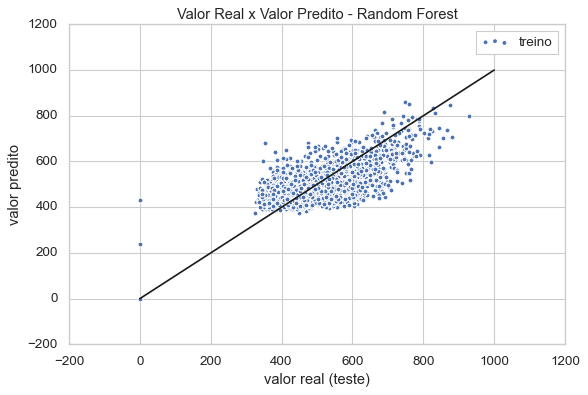

In [176]:
plt.scatter(y_test, y_pred, label='treino')
#plt.scatter(train_targets, train_predictions, label='train')

#plt.scatter(test_targets, test_predictions, label='test')
plt.plot(np.arange(0, 1000, 0.01), np.arange(0, 1000, 0.01), c='k')
plt.xlabel('valor real (teste)')
plt.ylabel('valor predito')
plt.title('Valor Real x Valor Predito - Random Forest')
plt.legend()
plt.show()

### XGBoost

In [167]:
from sklearn.ensemble import GradientBoostingRegressor

In [168]:
## XGB
# Import GradientBoostingRegressor

for nomeDf, dadosTreino in treinosDiciona.items():
    
    # dividindo treino e teste
    X = dadosTreino.drop('NU_NOTA_MT', axis=1)
    y = dadosTreino['NU_NOTA_MT']
    
    # 70% para treino
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Instantiate gb
    gb = GradientBoostingRegressor(max_depth=4,
                                   n_estimators=200,
                                   random_state=2)

    # Fit gb to the training set
    gb.fit(X_train, y_train)

    # Predict test set labels
    y_pred = gb.predict(X_test)

    # Compute MSE
    mse_test = MSE(y_test, y_pred)

    # Compute RMSE
    rmse_test = mse_test**(1/2)

    # Print RMSE
    print('base '+ nomeDf+'Teste RMSE do XBG: {:.3f}'.format(rmse_test))
    del gb


base baselineNAsTeste RMSE do XBG: 61.374
base knn5Teste RMSE do XBG: 64.614
base knn10Teste RMSE do XBG: 63.239


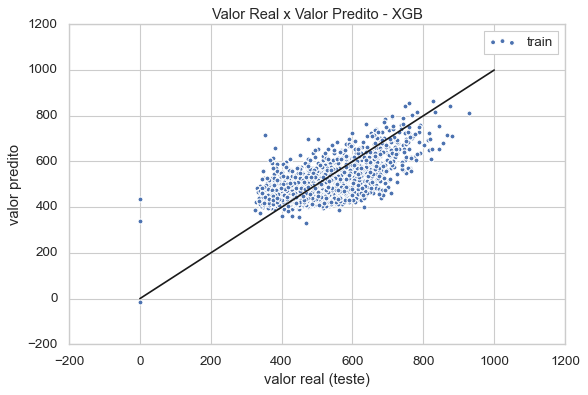

In [174]:
plt.scatter(y_test, y_pred, label='train')
#plt.scatter(train_targets, train_predictions, label='train')

#plt.scatter(test_targets, test_predictions, label='test')
plt.plot(np.arange(0, 1000, 0.01), np.arange(0, 1000, 0.01), c='k')
plt.xlabel('valor real (teste)')
plt.ylabel('valor predito')
plt.title('Valor Real x Valor Predito - XGB')
plt.legend()
plt.show()

In [205]:
dadosTreino = treinosDiciona['baselineNAs']
    # dividindo treino e teste
X = dadosTreino.drop('NU_NOTA_MT', axis=1)
y = dadosTreino['NU_NOTA_MT']
    
    # 70% para treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Instantiate gb
gb = GradientBoostingRegressor(max_depth=4,
                                   n_estimators=200,
                                   random_state=2)

    # Fit gb to the training set
gb.fit(X_train, y_train)

    # Predict test set labels
y_pred = gb.predict(X_test)

    # Compute MSE
mse_test = MSE(y_test, y_pred)

    # Compute RMSE
rmse_test = mse_test**(1/2)

    # Print RMSE
print('base '+ nomeDf+'Teste RMSE do XBG: {:.3f}'.format(rmse_test))

base knn10Teste RMSE do XBG: 61.374


In [207]:
testeSemNA = teste.fillna(-1)

y_pred = gb.predict(testeSemNA)

In [208]:
len(y_pred)

4576

In [210]:
testeOriginal = pd.read_csv('test.csv')

In [216]:
submeterDf = pd.DataFrame(
    data = {'NU_INSCRICAO': testeOriginal['NU_INSCRICAO'],
           'NU_NOTA_MT': y_pred
           })

In [217]:
submeterDf.head()

,NU_INSCRICAO,NU_NOTA_MT
0,73ff9fcc02f0a99919906c942c2e1a1042cdcf98,441.620267
1,71a95f9f1b91a82c65ad94abbdf9f54e6066f968,442.927797
2,b38a03232f43b11c9d0788abaf060f7366053b6d,604.554206
3,70b682d9a3636be23f6120fa9d6b164eb3c6002d,-0.722206
4,715494628a50142ce8cb17191cfe6d0f3cae0934,572.875167


In [218]:
submeterDf.to_csv('answer.csv', index=False)

## SVM (SVR - regressão)

In [178]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.utils import shuffle
import math

In [189]:
## XGB
# Import GradientBoostingRegressor

for nomeDf, dadosTreino in treinosDiciona.items():
    
    # dividindo treino e teste
    X = dadosTreino.drop('NU_NOTA_MT', axis=1)
    y = dadosTreino['NU_NOTA_MT']
    
    # 70% para treino
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Instantiate SVM
    svm = SVR()

    # Fit gb to the training set
    svm.fit(X_train, y_train)

    # Predict test set labels
    y_pred = svm.predict(X_test)

    # Compute MSE
    mse_test = MSE(y_test, y_pred)

    # Compute RMSE
    rmse_test = mse_test**(1/2)

    # Print RMSE
    print('base '+ nomeDf+'Teste RMSE do SVM: {:.3f}'.format(rmse_test))
    del svm


base baselineNAsTeste RMSE do SVM: 78.094
base knn5Teste RMSE do SVM: 72.496
base knn10Teste RMSE do SVM: 71.207


No código abaixo não é necessário separar treino e teste pois ele já faz a validação cruzada.

E também já está fazendo o ajuste dos hiperparâmetros.

In [184]:
# def svr_model(X, y):
#     gsc = GridSearchCV(
#         estimator=SVR(kernel='linear'),
#         param_grid={
#             'C': [0.1, 1, 100, 1000],
#             'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
#         },
#         cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)

#     grid_result = gsc.fit(X, y)
#     best_params = grid_result.best_params_best_svr = SVR(kernel='linear', C=best_params["C"], epsilon=best_params["epsilon"], coef0=0.1, shrinking=True,
#                    tol=0.001, cache_size=200, verbose=False, max_iter=-1)

#     scoring = {'abs_error': 'neg_mean_absolute_error',
#                'squared_error': 'neg_mean_squared_error'}
    
#     scores = cross_validate(best_svr, X, y, cv=10, scoring=scoring, return_train_score=True)
    
#     return "MAE :", abs(scores['test_abs_error'].mean()), "| RMSE :", math.sqrt(abs(scores['test_squared_error'].mean()))

## Ajuste dos hiperparametros

In [192]:
from sklearn.metrics import mean_squared_error as MSE

## Random Forest

In [199]:
dadosTreino = treinosDiciona['baselineNAs']

X = dadosTreino.drop('NU_NOTA_MT', axis=1)
y = dadosTreino['NU_NOTA_MT']

grid_param = {
    'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
    'max_features':  list(range(1,X.shape[1])),
    'max_depth':   np.linspace(1, 32, 32, endpoint=True),
    'min_samples_split':  np.linspace(0.1, 1.0, 10, endpoint=True),
    'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True)
}

from sklearn.model_selection import RandomizedSearchCV

RF = RandomForestRegressor(random_state=1)

RF_random = RandomizedSearchCV(
    estimator = RF,
	param_distributions = grid_param, n_iter = 500,
	cv = 5, verbose=2, random_state=42,
	n_jobs = -1)

RF_random.fit(X, y)

print(RF_random.best_params_)



Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  8.3min finished


{'n_estimators': 100, 'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_features': 82, 'max_depth': 21.0}


In [201]:
RF_random.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=21.0, max_features=82, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.1,
                      min_samples_split=0.2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [202]:
for nomeDf, dadosTreino in treinosDiciona.items():
    
    # dividindo treino e teste
    X = dadosTreino.drop('NU_NOTA_MT', axis=1)
    y = dadosTreino['NU_NOTA_MT']
    
    # 70% para treino
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Create a Random Forest Classifier with specified criterion
    rf = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=21.0, max_features=82, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=0.1,
                      min_samples_split=0.2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

    # Fit rf to the training set            
    rf.fit(X_train, y_train)                           

    # Predict the test set labels
    y_pred = rf.predict(X_test)

    # Evaluate the test set RMSE
    rmse_test = MSE(y_test, y_pred)**(1/2)

    # Print rmse_test
    print('base '+ nomeDf+' Teste RMSE do RF: {:.2f}'.format(rmse_test))
    
    del rf

base baselineNAs Teste RMSE do RF: 68.28
base knn5 Teste RMSE do RF: 71.35
base knn10 Teste RMSE do RF: 70.46
